In [2]:
import sys
sys.path.append('../..')

import numpy as np
from numpy.matlib import repmat
import pandas as pd
import eeg_decoder as eeg_decoder
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from mne.filter import filter_data
from scipy.signal import hilbert, chirp

from collections import Counter
%load_ext autoreload
%autoreload 2

In [3]:
experiment_name = 'd01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*behavior.csv')))

In [4]:
tois = np.arange(-200, 1001, 2)
times_bool = [1 if (t in tois) else 0 for t in exp.info['times']]
censor_times = exp.info['times'] > 1000 # values to convert to 0 to prevent leak backwards

In [5]:
time_window = 25
time_step = 25
trial_bin_size = 1 # not used
n_splits = 25
group_dict = {}

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
wrangl.t

array([-200, -176, -152, -128, -104,  -80,  -56,  -32,   -8,   16,   40,
         64,   88,  112,  136,  160,  184,  208,  232,  256,  280,  304,
        328,  352,  376,  400,  424,  448,  472,  496,  520,  544,  568,
        592,  616,  640,  664,  688,  712,  736,  760,  784,  808,  832,
        856,  880,  904,  928,  952,  976])

In [6]:
palette = {
    'N1': 'royalblue',
    'H1': 'forestgreen',
    'L1': 'coral',
    '2': 'maroon'
}

# Helpers

In [7]:
def makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx):
    assert len(Cond1Idx)==len(Cond2Idx) and len(posLabels)==len(Cond1Idx)
    
    nTrials = len(Cond1Idx); 
    blocks = np.full((nTrials), np.nan)
    
    C1_posLabels = posLabels[Cond1Idx]
    C2_posLabels = posLabels[Cond2Idx]
    
    binCnt = np.full((2, nBins), np.nan)
    for b in range(nBins):
        binCnt[0,b] = np.sum(C1_posLabels == b+1)
        binCnt[1,b] = np.sum(C2_posLabels == b+1)

    minCnt = np.min(binCnt)
    nPerBin = int(np.floor(minCnt/nBlocks))
    
    for c in [1, 2]:
        pBin = C1_posLabels if c==1 else C2_posLabels

        tmp_nTrials = len(pBin)
        shuffBlocks = np.full(pBin.shape, np.nan)

        # shuffle trials
        shuffInd = np.arange(tmp_nTrials)
        np.random.shuffle(shuffInd)
        shuffBin = pBin[shuffInd] # shuffle trial order

        # take the 1st nPerBin x nBlocks trials for each position bin.
        for b in range(nBins):
            idx = np.where(shuffBin == b+1)[0]  # get index for trials belonging to the current bin
            idx = idx[:nPerBin*nBlocks]  # drop excess trials
            x = repmat(np.arange(1, nBlocks+1), 1, nPerBin)
            shuffBlocks[idx] = x # assign trials to blocks

        if c==1:
            C1_Blocks = np.full(C1_posLabels.shape, np.nan)
            C1_Blocks[shuffInd] = shuffBlocks
        elif c==2:
            C2_Blocks = np.full(C2_posLabels.shape, np.nan)
            C2_Blocks[shuffInd] = shuffBlocks


    ## regular blocks is just two condLabels combined
    blocks[Cond1Idx] = C1_Blocks
    blocks[Cond2Idx] = C2_Blocks
    nTrialsPerBlock = np.sum(blocks==1) # of trials per block
    nTrialsPerBlock_C1 = np.sum(blocks[Cond1Idx]==1)
    nTrialsPerBlock_C2 = np.sum(blocks[Cond2Idx]==1)
    
    return(blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2)

In [8]:
def MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x):
    prediction = np.sin(0.5*x)**sinPower
    prediction = np.roll(prediction, 4, axis=0)
    basisSet = np.full((nChans, nBins), np.nan)
    basisSet[0, :] = prediction
    for c in range(1, nChans):
        basisSet[c, :] = prediction = np.roll(prediction, 1, axis=0)
    return(basisSet)

In [9]:
def MakeDeltaBasis_Square(nBins, nChans):
    
    assert nBins==nChans # for this sudy, we are using 5 and 5
    return(np.eye(nBins, nChans))
    

In [10]:
def sort_and_mean_CTF(ctf, shuffle=False): 
    # these are the quadrants
    
    # the channels for each bin get resorted to be 0=bin, then expanding outwards
    
    bin_idx = [0, 1, 2, 3, 4]
    if shuffle:
        bin_idx = np.random.permutation(bin_idx) # shuffle how each bin is treated

    ctf[bin_idx[0], :] = ctf[bin_idx[0], [0, 1, 4, 2, 3]]
    ctf[bin_idx[1], :] = ctf[bin_idx[1], [1, 2, 0, 3, 4]]
    ctf[bin_idx[2], :] = ctf[bin_idx[2], [2, 3, 1, 4, 0]]
    ctf[bin_idx[3], :] = ctf[bin_idx[3], [3, 4, 2, 0, 1]]
    ctf[bin_idx[4], :] = ctf[bin_idx[4], [4, 0, 3, 1, 2]]
    
    return np.mean(ctf, 0) # mean across bins

def CTF_Slope(ctf):
    x = [1, 2, 3]
    y = [ctf[0], ctf[[1,2]].mean(), ctf[[3,4]].mean()]
    return(np.polyfit(x, y, deg=1)[0]) # fit and get slope

In [11]:
# def center_and_mean_CTF(ctf, shuffle=False):
#     if shuffle:
#         ctf = np.random.permutation(ctf) # shuffle rows
        
#     ctf_aligned = ctf.copy()
#     nrows = ctf.shape[0]
#     for s in range(nrows):
#         ctf_aligned[s, :] = np.roll(ctf[s, :], -s) # align the centers to the first column
        
#     mean_ctf = np.mean(ctf_aligned, 0) # average across the rows (posLabels)
    
#     return(np.roll(mean_ctf, int(np.ceil(nrows/2)))) # shift to center

# def CTF_Slope(ctf):
#     x = [1, 2, 3, 4, 5]
#     y = [ctf[0], ctf[[1,7]].mean(), ctf[[2,6]].mean(), ctf[[3,5]].mean(), ctf[4]]
#     return(np.polyfit(x, y, deg=1)[0]) # fit and get slope

In [11]:
def IEM_2cond(totalPower, posLabels, condLabels, times_bool, sinPower=25, nBins=5, nChans=5, nIter=25, nBlocks=3, freq_bounds=[8, 12], time = tois, Fs=500, wrangl=wrangl):
    # ARGUMENTS
    # totalPower = alpha power of EEG data of shape nTrials, nElectrodes, nTimePoints
    # posLabels = list of spatial positions (in terms of bin number) for each trial
    # condLabels = list of condition labels (1 or 2) for each trial
    # sinPower = power of the response function 
    # nBins = num location bins
    # nChans = num channels (cell popluations)
    # nIter =  num iterations (input to function)
    # nBlocks = num blocks for cross-validation
    # freq_bounds = frequency range to analyze 
    # nSamps = num time points of interest
    # Fs = Sampling rate of EEG

    nSamps = len(time)
    nTrials = len(posLabels)
    nElectrodes = totalPower.shape[1]
    
    x = np.linspace(0, 2*np.pi-2*np.pi/nBins, nBins)
    basisSet = MakeDeltaBasis_Square(nBins, nChans)
    
    Cond1Idx = condLabels==1
    Cond2Idx = condLabels==2
    
    # Preallocate Output Matrices
    tf_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    
    sl_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    
    blocks = np.full((nTrials,nIter), np.nan)
    
    ## Filter and Organize Data into Blocks
    totalPower = np.squeeze(totalPower[:, :, np.where(times_bool)]) # subset to times-of-interest
    assert totalPower.shape[2]==nSamps
    
    ## create block assignments
    for i in range(nIter):
        (curr_blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2) = makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx);
        blocks[:,i] = curr_blocks
        
    tmpBlocks = blocks.copy()
    
    for i in range(nIter):
        curr_blocks = tmpBlocks[:,i]
        
        # Preallocate
        blockDat_total = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond1 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond2 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)

        labels = np.full((nBins*nBlocks), np.nan)
        blockNum = np.full((nBins*nBlocks), np.nan)
        c = np.full((nBins*nBlocks, nChans), np.nan)

        # Average data for each bin across blocks
        counter = 0
        for j in range(nBins):
            for k in range(nBlocks):
                # all data for training
                blockDat_total[counter,:,:] = np.mean(totalPower[(posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond1 Test
                blockDat_total_Cond1[counter,:,:] = np.mean(totalPower[(Cond1Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond2 Test
                blockDat_total_Cond2[counter,:,:] = np.mean(totalPower[(Cond2Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)

                # info
                labels[counter] = j
                blockNum[counter] = k
                c[counter,:] = basisSet[j,:]
                counter+=1

        # run IEM on each timepoint
        for t in range(len(wrangl.t)):
            time_window_idx = (wrangl.samples >= wrangl.t[t]) & (
                wrangl.samples < wrangl.t[t] + wrangl.time_window)
            
            dt = np.mean(blockDat_total[:, :, time_window_idx], 2)
            dt_Cond1 = np.mean(blockDat_total_Cond1[:,:,time_window_idx], 2)
            dt_Cond2 = np.mean(blockDat_total_Cond2[:,:,time_window_idx], 2)

            for b in range(nBlocks): # hold out each block as the test set, train on the other 2
                train_labels = labels[blockNum!=b]
                test_labels = labels[blockNum==b]

                C1 = c[blockNum!=b, :]
                B1 = dt[blockNum!=b, :]
                B2_Cond1 = dt_Cond1[blockNum==b, :]
                B2_Cond2 = dt_Cond2[blockNum==b, :]

                # fit model and record res
                channel_weights = np.linalg.lstsq(C1, B1, rcond=None)[0]
                
                recon1 = np.linalg.lstsq(channel_weights.T , B2_Cond1.T, rcond=None)[0].T
                CTF_C1 = sort_and_mean_CTF(recon1);
                CTF_C1_shuff = sort_and_mean_CTF(recon1, shuffle=True)
                
                recon2 = np.linalg.lstsq(channel_weights.T , B2_Cond2.T, rcond=None)[0].T
                CTF_C2 = sort_and_mean_CTF(recon2);
                CTF_C2_shuff = sort_and_mean_CTF(recon2, shuffle=True)
                
                
                # record CTFs
                tf_total_Cond1[i,t,b,:] = CTF_C1
                tf_total_Cond1_shuff[i,t,b,:] = CTF_C1_shuff
                tf_total_Cond2[i,t,b,:] = CTF_C2
                tf_total_Cond2_shuff[i,t,b,:] = CTF_C2_shuff
                
                # record slopes
                sl_total_Cond1[i,t,b] = CTF_Slope(CTF_C1)
                sl_total_Cond1_shuff[i,t,b] = CTF_Slope(CTF_C1_shuff)
                sl_total_Cond2[i,t,b] = CTF_Slope(CTF_C2)
                sl_total_Cond2_shuff[i,t,b] = CTF_Slope(CTF_C2_shuff)

                
    return {
        'CTFs': {
            'Cond1': tf_total_Cond1,
            'Cond1_shuff': tf_total_Cond1_shuff,
            'Cond2': tf_total_Cond2,
            'Cond2_shuff': tf_total_Cond2_shuff,
        },
        'slopes': {
            'Cond1': sl_total_Cond1,
            'Cond1_shuff': sl_total_Cond1_shuff,
            'Cond2': sl_total_Cond2,
            'Cond2_shuff': sl_total_Cond2_shuff,
        }
    }

# setup and clean up data

In [12]:
def get_second_bin(bin_str):
    try:
        return int(bin_str[4])
    except:
        return np.nan

In [13]:
xdata_dict = {}
behavior_dict = {}

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata[:,:,censor_times] = 0 # censor timepoints to prevent bleeding backwards

    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()

    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = behavior[behavior.Block.notnull()] # cut out original post-task stuff
    
    if len(behavior)!=noArt_idx.shape[0]:
        print(f'error on isub {isub}; won\'t be included')
        continue
        
    behavior = behavior.loc[noArt_idx, :].reset_index(drop=True)
    assert len(behavior)==xdata.shape[0]

    behavior['Bin'] = behavior.Quintants.apply(lambda x: int(x[1])).values
    behavior['OtherBin'] = behavior.Quintants.apply(get_second_bin).values
    
    xdata_dict[isub] = np.abs(hilbert(filter_data(xdata.astype(np.float64), 500, 8, 12)))**2 # convert to total alpha power
    behavior_dict[isub] = behavior

0
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)

1
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)


In [14]:
def make_CTF_df(results_dict, isub, cond, condname, wrangl=wrangl, t=200):
    sub_CTFs = pd.DataFrame()
    # mean across iterations, blocks, ignore the first 200ms before meaning across time
    sub_CTFs['Response'] = results_dict[isub]['CTFs'][cond].mean(0).mean(1)[wrangl.t > t, :].mean(0)
    sub_CTFs['Channel'] = np.arange(1,6)
    sub_CTFs['PID'] = isub
    sub_CTFs['condition'] = condname
    return(sub_CTFs)

In [15]:
def make_slope_df(results, isub, cond, condname, time=wrangl.t):
    sub_slopes = pd.DataFrame()
    sub_slopes['time'] = time
    sub_slopes['Slope'] = results[isub]['slopes'][cond].mean(0).mean(1)
    sub_slopes['PID'] = isub
    sub_slopes['condition'] = condname
    return(sub_slopes)

## Pipeline

In [16]:
sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))
palette = ['forestgreen', 'orange']

In [17]:
def compare_two_conds(low, high, xdata_dict=xdata_dict, behavior_dift=behavior_dict, bin_col='Bin',ax=None):
    cond_map = {
        low: 1,
        high: 2
    }
    
    IEM_results = {}

    for isub in xdata_dict:
        xdata = xdata_dict[isub]
        behavior = behavior_dict[isub]

        subset_idx = behavior.Condition.isin([low, high])

        xdata = xdata[subset_idx]
        posLabels = behavior.loc[subset_idx, bin_col].values + 1 # shift from 0-4 to 1-5
        condLabels = behavior.loc[subset_idx, 'Condition'].values

        condLabels = np.array(list(map(cond_map.get, condLabels))) # convert to 1s and 2s

        print(isub, Counter(condLabels))

        IEM_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool)
        
    # plot slope results
    slope_df = pd.DataFrame()
    for isub in IEM_results:
        sub_slopes_obs = pd.concat([make_slope_df(IEM_results, isub, 'Cond1', low),
               make_slope_df(IEM_results, isub, 'Cond2', high)])
        sub_slopes_obs['method'] = 'Observed'

        sub_slopes_shuff = pd.concat([make_slope_df(IEM_results, isub, 'Cond1_shuff', low),
               make_slope_df(IEM_results, isub, 'Cond2_shuff', high)])
        sub_slopes_shuff['method'] = 'Shuffled'

        slope_df = pd.concat([slope_df, sub_slopes_obs, sub_slopes_shuff])

    slope_df = slope_df.reset_index(drop=True)
    slope_df.Slope *= -1
    print(slope_df.columns)
    
    # plot CTF reconstructed 
    CTF_df = pd.DataFrame()
    for isub in IEM_results:
        sub_CTFs_obs = pd.concat([make_CTF_df(IEM_results, isub, 'Cond1', low),
               make_CTF_df(IEM_results, isub, 'Cond2', high)])
        sub_CTFs_obs['method'] = 'Observed'

        sub_CTFs_shuff = pd.concat([make_CTF_df(IEM_results, isub, 'Cond1_shuff', low),
               make_CTF_df(IEM_results, isub, 'Cond2_shuff', high)])
        sub_CTFs_shuff['method'] = 'Shuffled'


        CTF_df = pd.concat([CTF_df, sub_CTFs_obs, sub_CTFs_shuff])

    CTF_df = CTF_df.reset_index(drop=True)

    return CTF_df,slope_df

# actual analysis

In [18]:
_,slope_vdis_target = compare_two_conds('ss1_vdis', 'ss2', bin_col='Bin')
_,slope_vdis_dist = compare_two_conds('ss1_vdis', 'ss2', bin_col='OtherBin')
_,slope_dis_target = compare_two_conds('ss1_dis', 'ss2', bin_col='Bin')
_,slope_dis_dist = compare_two_conds('ss1_dis', 'ss2', bin_col='OtherBin')
_,slope_sim_target = compare_two_conds('ss1_sim', 'ss2', bin_col='Bin')
_,slope_sim_dist = compare_two_conds('ss1_sim', 'ss2', bin_col='OtherBin')

0 Counter({2: 240, 1: 239})
1 Counter({1: 283, 2: 277})
2 Counter({2: 241, 1: 191})
3 Counter({2: 227, 1: 224})
4 Counter({1: 275, 2: 274})
5 Counter({2: 285, 1: 284})
6 Counter({2: 269, 1: 248})
7 Counter({2: 260, 1: 251})
8 Counter({2: 250, 1: 250})
9 Counter({2: 283, 1: 272})
10 Counter({2: 295, 1: 267})
11 Counter({1: 267, 2: 265})
12 Counter({2: 275, 1: 263})
13 Counter({1: 230, 2: 226})
14 Counter({2: 255, 1: 236})
15 Counter({1: 239, 2: 227})
16 Counter({2: 252, 1: 242})
17 Counter({2: 289, 1: 282})
18 Counter({2: 202, 1: 186})
19 Counter({2: 264, 1: 261})
20 Counter({1: 242, 2: 227})
21 Counter({2: 273, 1: 264})
22 Counter({2: 274, 1: 273})
23 Counter({1: 277, 2: 249})
Index(['time', 'Slope', 'PID', 'condition', 'method'], dtype='object')
0 Counter({2: 240, 1: 239})
1 Counter({1: 283, 2: 277})
2 Counter({2: 241, 1: 191})
3 Counter({2: 227, 1: 224})
4 Counter({1: 275, 2: 274})
5 Counter({2: 285, 1: 284})
6 Counter({2: 269, 1: 248})
7 Counter({2: 260, 1: 251})
8 Counter({2: 250, 

In [19]:
def concat(dfa,dfb,string):
    
    target = dfa.query(f'condition=="{string}"').reset_index()
    dist = dfb.query(f'condition=="{string}"').reset_index()
    target['Target'] = 'target'
    dist['Target'] = 'distractor'
    return pd.concat([target,dist])

In [20]:
x_vdis = concat(slope_vdis_target,slope_vdis_dist,'ss1_vdis')
x_dis = concat(slope_dis_target,slope_dis_dist,'ss1_dis')
x_sim = concat(slope_sim_target,slope_sim_dist,'ss1_sim')
x_ss2 = concat(slope_dis_target,slope_dis_dist,'ss2')

In [21]:
x_vdis['ss'] = 1
x_dis['ss'] = 1
x_sim['ss'] = 1
x_ss2['ss'] = 2
x_ss2['Target'] = 'target'

In [22]:
x_all = pd.concat([x_vdis,x_dis,x_sim,x_ss2]).query('method=="Observed"').reset_index()

In [141]:
x_all.to_csv('output/iems_new.csv')

In [36]:
x_all = pd.read_csv('output/iems_new.csv')
x_all = x_all.drop(['Unnamed: 0','level_0','index','Time Period'],axis=1)
x_all.head()

,time,Slope,PID,condition,method,Target,ss,label,label_all,Time
0,-200,-0.041156,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
1,-176,-0.178580,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
2,-152,-0.175717,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
3,-128,-0.093920,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
4,-104,-0.050670,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre


In [39]:
def cond_label(row):
    if (row['Target'] == 'target') & (row['ss'] == 1):
        return 'ss1_target'
    if row['ss'] == '2':
        return 'ss2_target'
    else:
        return f'{row["Target"]}_{row["condition"]}'
x_all['label'] = x_all.apply(cond_label,axis=1)
x_all.head()

,time,Slope,PID,condition,method,Target,ss,label,label_all,Time
0,-200,-0.041156,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
1,-176,-0.178580,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
2,-152,-0.175717,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
3,-128,-0.093920,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
4,-104,-0.050670,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre


In [40]:
x_all.label.unique()

array(['ss1_target', 'distractor_ss1_vdis', 'distractor_ss1_dis',
       'distractor_ss1_sim', 'target_ss2'], dtype=object)

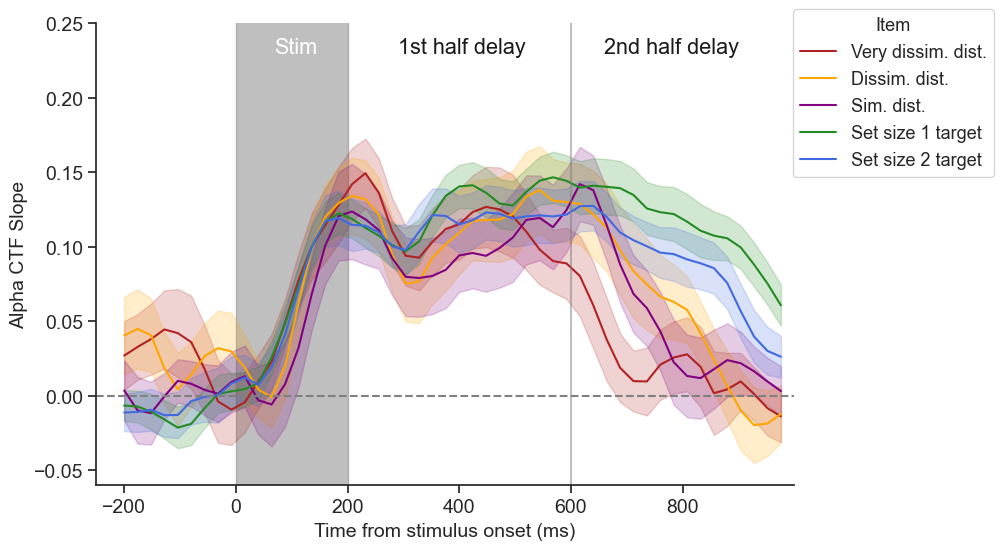

In [159]:
plt.close()
colors = ['firebrick', 'orange','purple','forestgreen','royalblue']

fig,ax =plt.subplots(figsize=(9,6))
ax.fill_between([0,200], [-1, -1], [
                1, 1], color='gray', alpha=.5)
sns.lineplot(data=x_all,x='time',y='Slope',hue='label',ax=ax,legend=True,errorbar='se',
             palette=colors, hue_order=['distractor_ss1_vdis','distractor_ss1_dis','distractor_ss1_sim','ss1_target','target_ss2'])
ax.axhline(y=0, color='grey', linestyle='--')
ax.axvline(x=600, color='grey', alpha=.5,linestyle='-')

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time from stimulus onset (ms)',fontsize=14)
ax.set_ylabel('Alpha CTF Slope',fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.ylim(-.06,.25)
plt.xlim(-250,999)
ax.text(68,.23,'Stim',color='w')
ax.text(290,.23,'1st half delay',color='k')
ax.text(660,.23,'2nd half delay',color='k')

leg = ax.legend(title='Item',fontsize=13,bbox_to_anchor=(1.3, 1.05))
labels=['Very dissim. dist.','Dissim. dist.','Sim. dist.','Set size 1 target','Set size 2 target']
for i,l in enumerate(leg.get_texts()):
    l.set_text(labels[i])

plt.setp(leg.get_title(),fontsize=13)
# plt.title('CTF Slope',fontsize=16)

# plt.savefig('output/figures/iem_new.png',dpi=500,bbox_inches='tight')
# plt.savefig('output/figures/iem_new.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [42]:
x_all['label_all'] = x_all.apply(lambda x: f'{x["Target"]}_{x["condition"]}',axis=1)

In [44]:
label = []
def assign_timebin(row):
    if row['time']<0:
        return 'Pre'
    elif (row['time']<200):
        return 'Stim'
    elif (row['time']>200) & (row['time'] < 600):
        return 'First half'
    else:
        return 'Second half'
x_all['Time'] = x_all.apply(assign_timebin,axis=1)

In [45]:
x_all

,time,Slope,PID,condition,method,Target,ss,label,label_all,Time
0,-200,-0.041156,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
1,-176,-0.178580,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
2,-152,-0.175717,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
3,-128,-0.093920,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
4,-104,-0.050670,0,ss1_vdis,Observed,target,1,ss1_target,target_ss1_vdis,Pre
...,...,...,...,...,...,...,...,...,...,...
9595,880,-0.094748,23,ss2,Observed,target,2,target_ss2,target_ss2,Second half
9596,904,-0.048566,23,ss2,Observed,target,2,target_ss2,target_ss2,Second half
9597,928,-0.039508,23,ss2,Observed,target,2,target_ss2,target_ss2,Second half
9598,952,-0.065206,23,ss2,Observed,target,2,target_ss2,target_ss2,Second half


In [67]:
subject_means = x_all.drop(['method','label','label_all'],axis=1).groupby(['PID','condition','Target','Time']).mean().reset_index().rename(columns={'condition':'Condition','label_all':'Label'})

In [68]:
subject_means

,PID,Condition,Target,Time,time,Slope,ss
0,0,ss1_dis,distractor,First half,400.0,0.012214,1.0
1,0,ss1_dis,distractor,Pre,-104.0,0.061253,1.0
2,0,ss1_dis,distractor,Second half,796.0,0.040743,1.0
3,0,ss1_dis,distractor,Stim,100.0,0.056486,1.0
4,0,ss1_dis,target,First half,400.0,0.096041,1.0
...,...,...,...,...,...,...,...
667,23,ss1_vdis,target,Stim,100.0,-0.117855,1.0
668,23,ss2,target,First half,400.0,0.033128,2.0
669,23,ss2,target,Pre,-104.0,-0.022487,2.0
670,23,ss2,target,Second half,796.0,-0.058257,2.0


C:\Users\William\AppData\Local\Temp\ipykernel_17536\4230608015.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([''])
C:\Users\William\AppData\Local\Temp\ipykernel_17536\4230608015.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels([''])


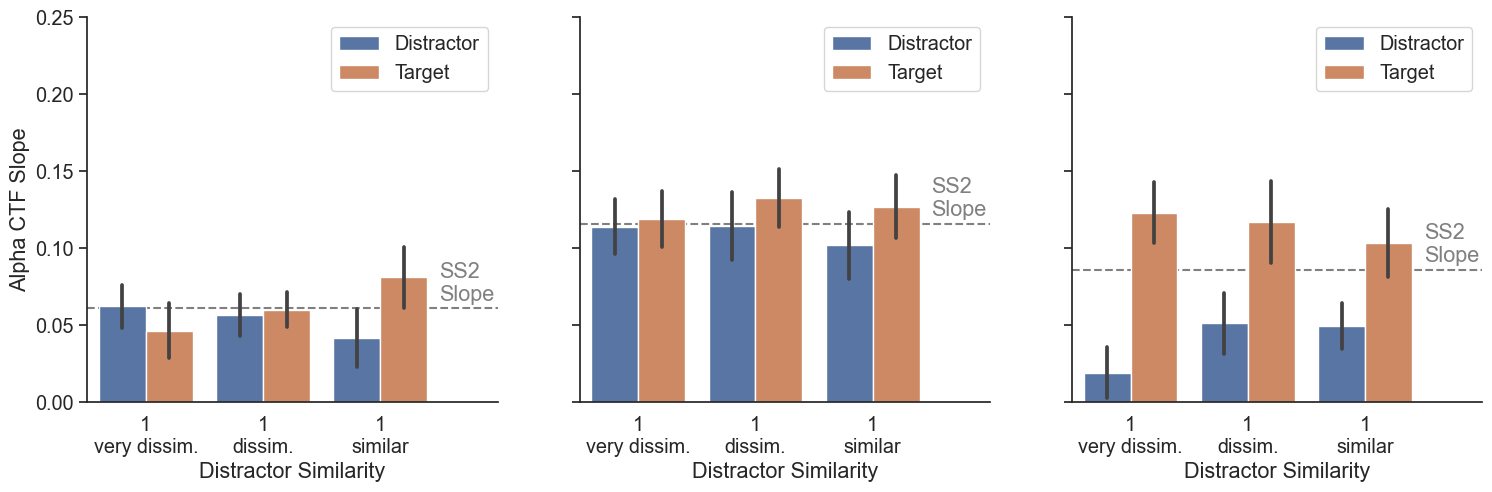

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=1.3,style='white',rc=custom_params)
fig,ax = plt.subplots(1,3,figsize=(18,5))

sns.barplot(
    x='Condition',y='Slope', hue='Target',
    data=subject_means.query('(Time=="Stim")&(Condition!="ss2")'),ax=ax[0],
    errorbar='se',
    order=['ss1_vdis','ss1_dis','ss1_sim'],
    dodge=True)
ss2_slope = subject_means.query('(Time=="Stim")&(Condition=="ss2")')['Slope'].mean()
ax[0].axhline(
    y=ss2_slope,
    linestyle='--',color='gray',zorder=-1)
ax[0].text(x=2.5,y = ss2_slope+.005, s='SS2\nSlope',color='gray')
ax[0].set_ylabel('Alpha CTF Slope')
ax[0].yaxis.set_ticks_position('left')

# First half
sns.barplot(
    x='Condition',y='Slope', hue='Target',
    data=subject_means.query('(Time=="First half")&(Condition!="ss2")'),ax=ax[1],#palette= colors,
    errorbar='se',
    order=['ss1_vdis','ss1_dis','ss1_sim'],
    dodge=True)
ss2_slope = subject_means.query('(Time=="First half")&(Condition=="ss2")')['Slope'].mean()
ax[1].axhline(
    y=ss2_slope,
    linestyle='--',color='gray',zorder=-1)
ax[1].text(x=2.5,y = ss2_slope+.005, s='SS2\nSlope',color='gray')
ax[1].yaxis.set_ticks_position('left')
ax[1].set_yticklabels([''])
ax[1].set_ylabel('')

# second half
sns.barplot(
    x='Condition',y='Slope', hue='Target',
    data=subject_means.query('(Time=="Second half")&(Condition!="ss2")'),ax=ax[2],#palette= colors,
    order=['ss1_vdis','ss1_dis','ss1_sim'],
    errorbar='se',
    dodge=True)
ss2_slope = subject_means.query('(Time=="Second half")&(Condition=="ss2")')['Slope'].mean()
ax[2].axhline(
    y=ss2_slope,
    linestyle='--',color='gray',zorder=-1)
ax[2].text(x=2.5,y = ss2_slope+.005, s='SS2\nSlope',color='gray')
ax[2].yaxis.set_ticks_position('left')
ax[2].set_yticklabels([''])
ax[2].set_ylabel('')

for a in ax:
    a.set_ylim(0,.25)
    a.set_xticklabels(['1\nvery dissim.','1\ndissim.','1\nsimilar'])
    leg = a.get_legend()
    leg.set_title("")
    leg.get_texts()[0].set_text('Distractor')
    leg.get_texts()[1].set_text('Target')
    a.set_xlim(-.5,3)
    a.set_xlabel('Distractor Similarity')

plt.savefig('output/figures/iembar.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/iembar.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [70]:
subject_means.groupby(['Condition','Target','Time']).agg(['mean','std'])['Slope']

mean       std
Condition Target     Time                           
ss1_dis   distractor First half   0.114502  0.108056
                     Pre          0.027957  0.090038
                     Second half  0.051241  0.096578
                     Stim         0.056661  0.067698
          target     First half   0.132570  0.092771
                     Pre          0.001615  0.098227
                     Second half  0.117030  0.129264
                     Stim         0.060105  0.055885
ss1_sim   distractor First half   0.102014  0.106434
                     Pre          0.001634  0.062995
                     Second half  0.049640  0.073762
                     Stim         0.041728  0.092746
          target     First half   0.126882  0.100518
                     Pre         -0.020405  0.060139
                     Second half  0.103193  0.108011
                     Stim         0.080973  0.096349
ss1_vdis  distractor First half   0.114022  0.087420
                     Pre          0.025057  0.100127
                     Second half  0.019146  0.080697
                     Stim         0.062202  0.068842
          target     First half   0.118674  0.089249
                     Pre         -0.009296  0.068593
                     Second half  0.123004  0.097282
                     Stim         0.046403  0.086613
ss2       target     First half   0.115848  0.072463
                     Pre         -0.005861  0.051445
                     Second half  0.085948  0.084236
                     Stim         0.060933  0.064371

In [122]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model_stim = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)', data=subject_means.loc[subject_means['Time']=='Stim']).fit();
anova_table_stim = sm.stats.anova_lm(model_stim, typ=1);
anova_table_stim

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.001378,0.000459,0.076579,0.972558
C(Target),1.0,0.002892,0.002892,0.482342,0.488365
C(Condition):C(Target),3.0,0.024913,0.008304,1.384852,0.249359
Residual,161.0,0.965439,0.005997,NaN,NaN


In [72]:
model_first = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)', data=subject_means.loc[subject_means['Time']=='First half']).fit();
anova_table_first = sm.stats.anova_lm(model_first, typ=1);
anova_table_first

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.002311,0.000770,0.086187,0.967518
C(Target),1.0,0.009058,0.009058,1.013343,0.315614
C(Condition):C(Target),3.0,0.009172,0.003057,0.342008,0.794977
Residual,161.0,1.439181,0.008939,NaN,NaN


In [73]:
model_second = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)', data=subject_means.loc[subject_means['Time']=='Second half']).fit();
anova_table_second = sm.stats.anova_lm(model_second, typ=1);
anova_table_second

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.005710,0.001903,0.201217,0.895427
C(Target),1.0,0.199271,0.199271,21.066046,0.000009
C(Condition):C(Target),3.0,0.019597,0.006532,0.690576,0.559050
Residual,161.0,1.522952,0.009459,NaN,NaN


In [74]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model_stim = ols('Slope ~ C(Condition) + C(Target) + C(Condition)*C(Target)*C(Time) + C(Time)', data=subject_means).fit();
anova_table_stim = sm.stats.anova_lm(model_stim, typ=1);
anova_table_stim

,df,sum_sq,mean_sq,F,PR(>F)
C(Condition),3.0,0.009870,0.003290,0.431492,7.305155e-01
C(Target),1.0,0.046200,0.046200,6.059583,1.409205e-02
C(Time),3.0,1.152256,0.384085,50.376220,2.948383e-29
C(Condition):C(Target),3.0,0.003422,0.001141,0.149602,9.299445e-01
C(Condition):C(Time),9.0,0.016853,0.001873,0.245596,9.875211e-01
C(Target):C(Time),3.0,0.191626,0.063875,8.377802,1.805994e-05
C(Condition):C(Target):C(Time),9.0,0.049808,0.005534,0.725860,6.853987e-01
Residual,644.0,4.910075,0.007624,NaN,NaN
